In [ ]:
# https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?resource=download

In [1]:
!pip install pyclustertend==1.9.0
!pip install diptest==0.9.0
!pip install pyclustering

In [2]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import pickle
from copy import deepcopy
from abc import ABC, abstractmethod
from sklearn.preprocessing import label_binarize
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from pyclustertend import hopkins
from sklearn.cluster import KMeans, Birch, DBSCAN
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.spatial.distance import cdist
import mlflow
import mlflow.sklearn
import diptest
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('passenger/train.csv')
df = df.drop(columns=['satisfaction', 'Unnamed: 0', 'id'])

In [4]:
def format_feature_name(feature):
    """
    Rename feature to follow coding standards.

    Arguments:
        feature (str): raw feature name.

    Returns:
        processed feature name as a string.
    """
    feature = feature.strip().replace('&', 'and').replace('/', '_').replace(' ', '_').replace('-', '_').lower()

    return feature

df.columns = [format_feature_name(feature=col) for col in df.columns]

<h2>EDA</h2>

In [6]:
df.head()

,gender,customer_type,age,type_of_travel,class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0


In [7]:
df.isnull().sum()

gender                                 0
customer_type                          0
age                                    0
type_of_travel                         0
class                                  0
flight_distance                        0
inflight_wifi_service                  0
departure_arrival_time_convenient      0
ease_of_online_booking                 0
gate_location                          0
food_and_drink                         0
online_boarding                        0
seat_comfort                           0
inflight_entertainment                 0
on_board_service                       0
leg_room_service                       0
baggage_handling                       0
checkin_service                        0
inflight_service                       0
cleanliness                            0
departure_delay_in_minutes             0
arrival_delay_in_minutes             310
dtype: int64

In [8]:
df[['departure_delay_in_minutes', 'arrival_delay_in_minutes']].corr()

,departure_delay_in_minutes,arrival_delay_in_minutes
departure_delay_in_minutes,1.000000,0.965481
arrival_delay_in_minutes,0.965481,1.000000


In [9]:
df[['departure_delay_in_minutes', 'arrival_delay_in_minutes']].mean()

departure_delay_in_minutes    14.815618
arrival_delay_in_minutes      15.178678
dtype: float64

In [10]:
ix = df['arrival_delay_in_minutes'].isnull()
df.loc[ix, 'arrival_delay_in_minutes'] = df.loc[ix, 'departure_delay_in_minutes']

In [11]:
df.isnull().sum()

gender                               0
customer_type                        0
age                                  0
type_of_travel                       0
class                                0
flight_distance                      0
inflight_wifi_service                0
departure_arrival_time_convenient    0
ease_of_online_booking               0
gate_location                        0
food_and_drink                       0
online_boarding                      0
seat_comfort                         0
inflight_entertainment               0
on_board_service                     0
leg_room_service                     0
baggage_handling                     0
checkin_service                      0
inflight_service                     0
cleanliness                          0
departure_delay_in_minutes           0
arrival_delay_in_minutes             0
dtype: int64

In [12]:
df.duplicated().any()

False

In [13]:
df.describe()

,age,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.245072
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.808674
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [14]:
df.loc[df['departure_delay_in_minutes'] > 1000]

,gender,customer_type,age,type_of_travel,class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes
6744,Male,Loyal Customer,32,Business travel,Business,2916,2,2,2,2,5,5,5,3,4,5,4,5,3,5,1305,1280.0
61310,Male,Loyal Customer,49,Business travel,Business,1959,1,1,1,1,4,4,4,4,4,4,5,4,4,4,1017,1011.0
83741,Female,Loyal Customer,47,Personal Travel,Eco,1120,2,2,2,3,2,4,2,2,4,4,4,2,3,2,1592,1584.0


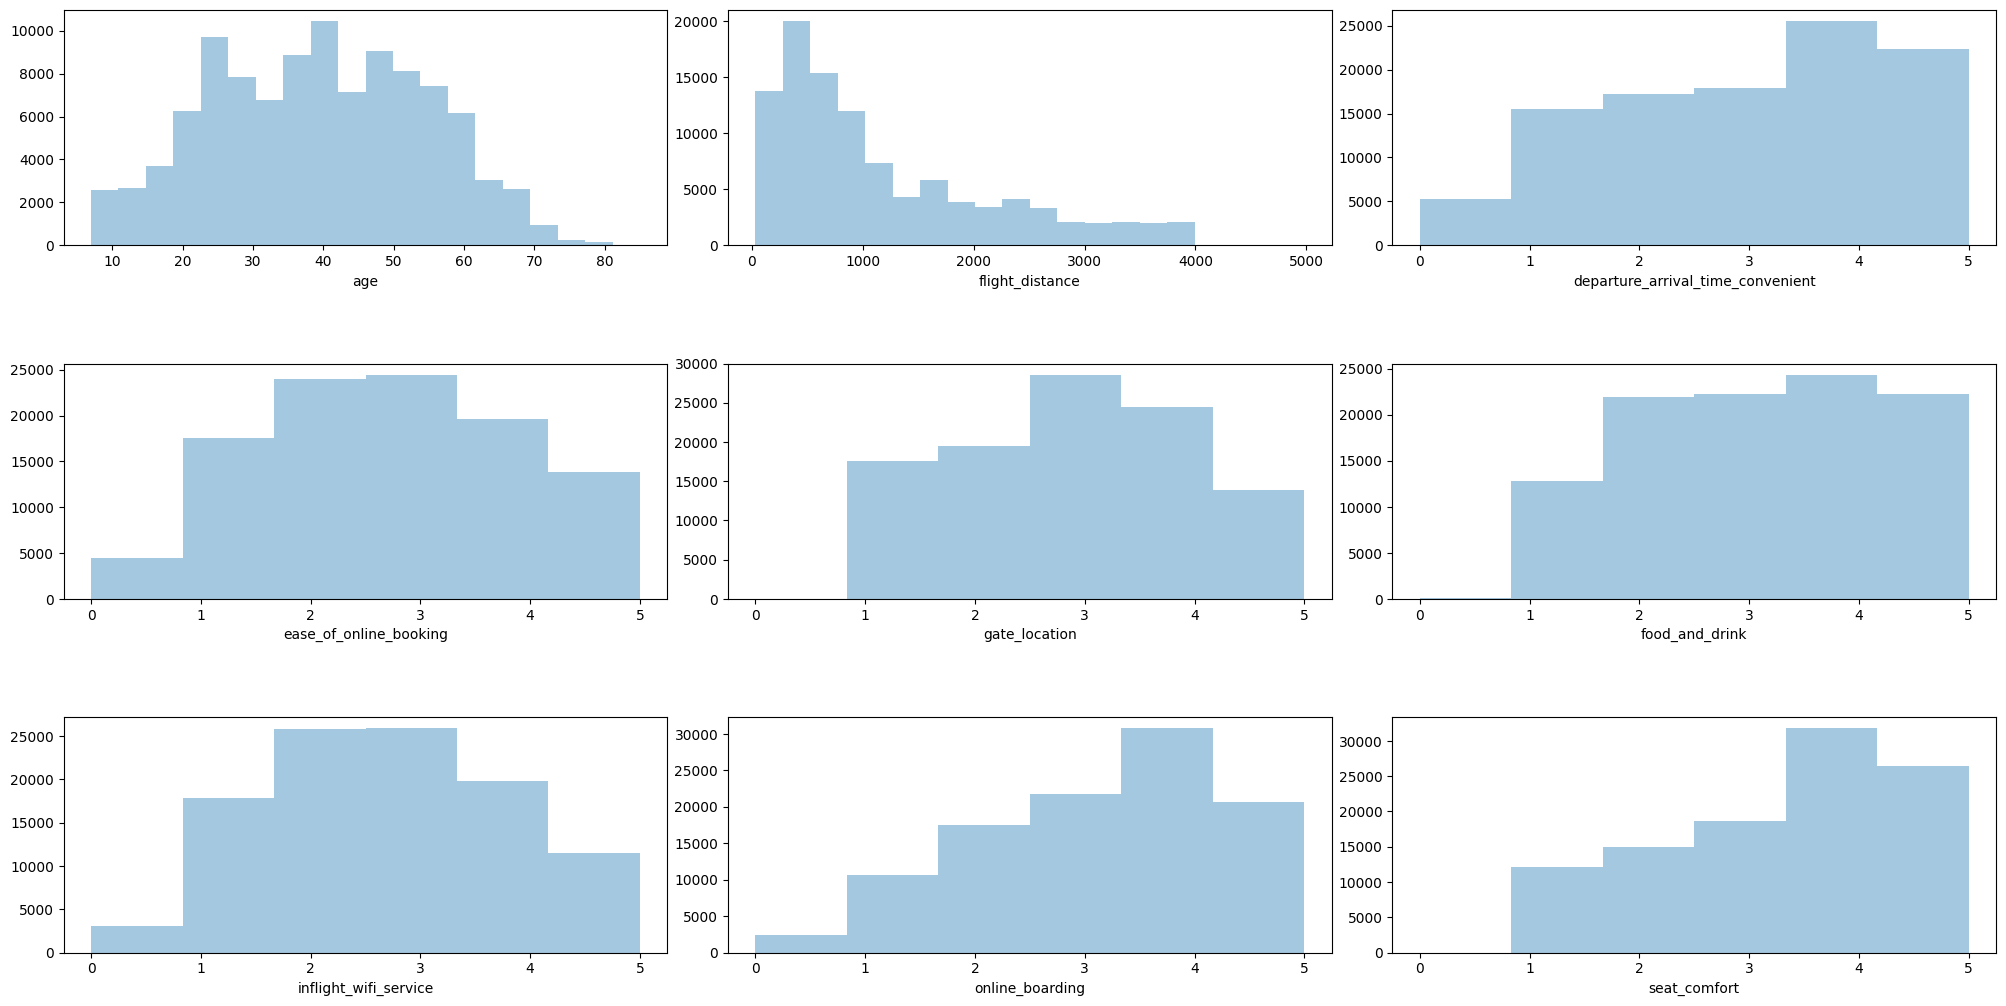

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))
index = 0
axs = axs.flatten()
num_cols_1 = [
    'age',
    'flight_distance',
    'departure_arrival_time_convenient',
    'ease_of_online_booking',
    'gate_location',
    'food_and_drink',
    'inflight_wifi_service', 
    'online_boarding',
    'seat_comfort',
]
for num_col in num_cols_1:
    num_unique_vals = df[num_col].nunique()
    num_bins = np.min([num_unique_vals, 20])
    sns.distplot(df[num_col], ax=axs[index], kde=False, bins=num_bins)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

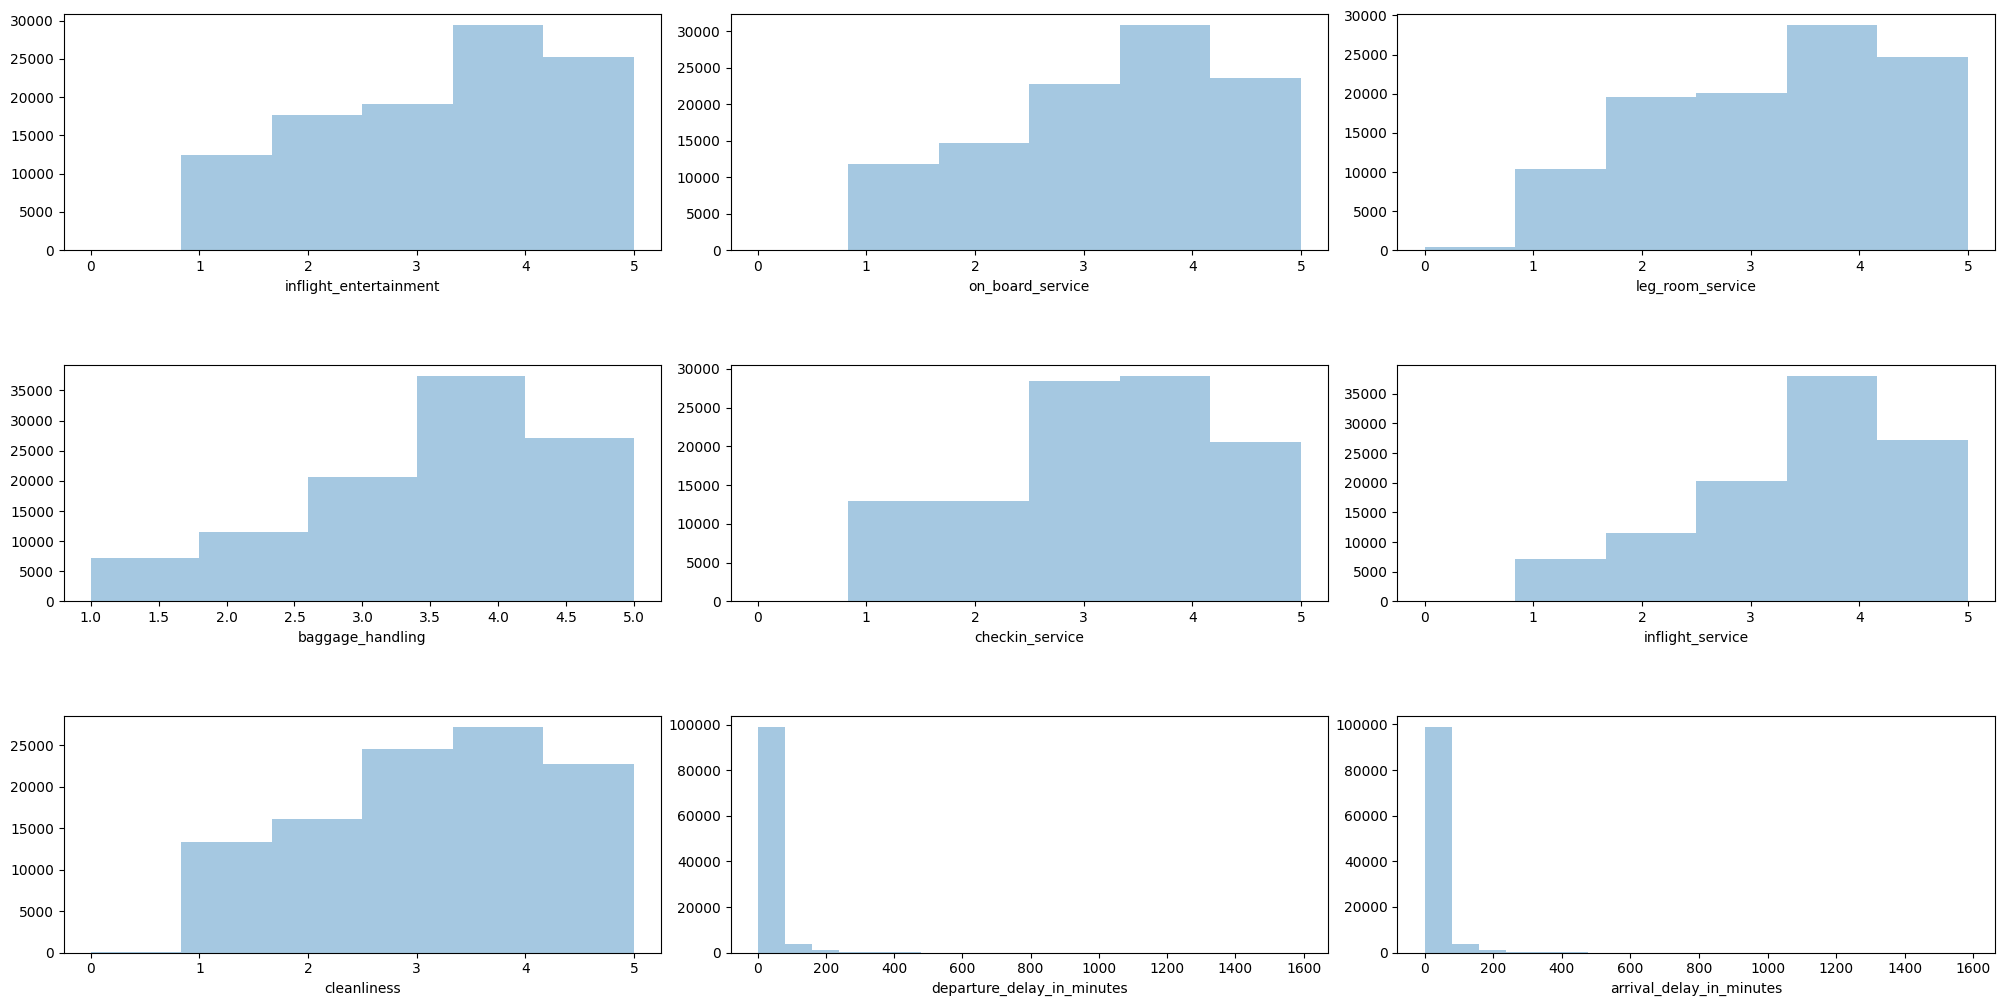

In [16]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))
index = 0
axs = axs.flatten()
num_cols_2 = [
    'inflight_entertainment',
    'on_board_service',
    'leg_room_service',
    'baggage_handling',
    'checkin_service',
    'inflight_service',
    'cleanliness',
    'departure_delay_in_minutes',
    'arrival_delay_in_minutes',
]
for num_col in num_cols_2:
    num_unique_vals = df[num_col].nunique()
    num_bins = np.min([num_unique_vals, 20])
    sns.distplot(df[num_col], ax=axs[index], kde=False, bins=num_bins)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

In [17]:
for col in ['departure_delay_in_minutes', 'arrival_delay_in_minutes']:
    new_col = f'{col}_log'
    df[new_col] = np.log(1 + df[col])
    df = df.drop(columns=[col])

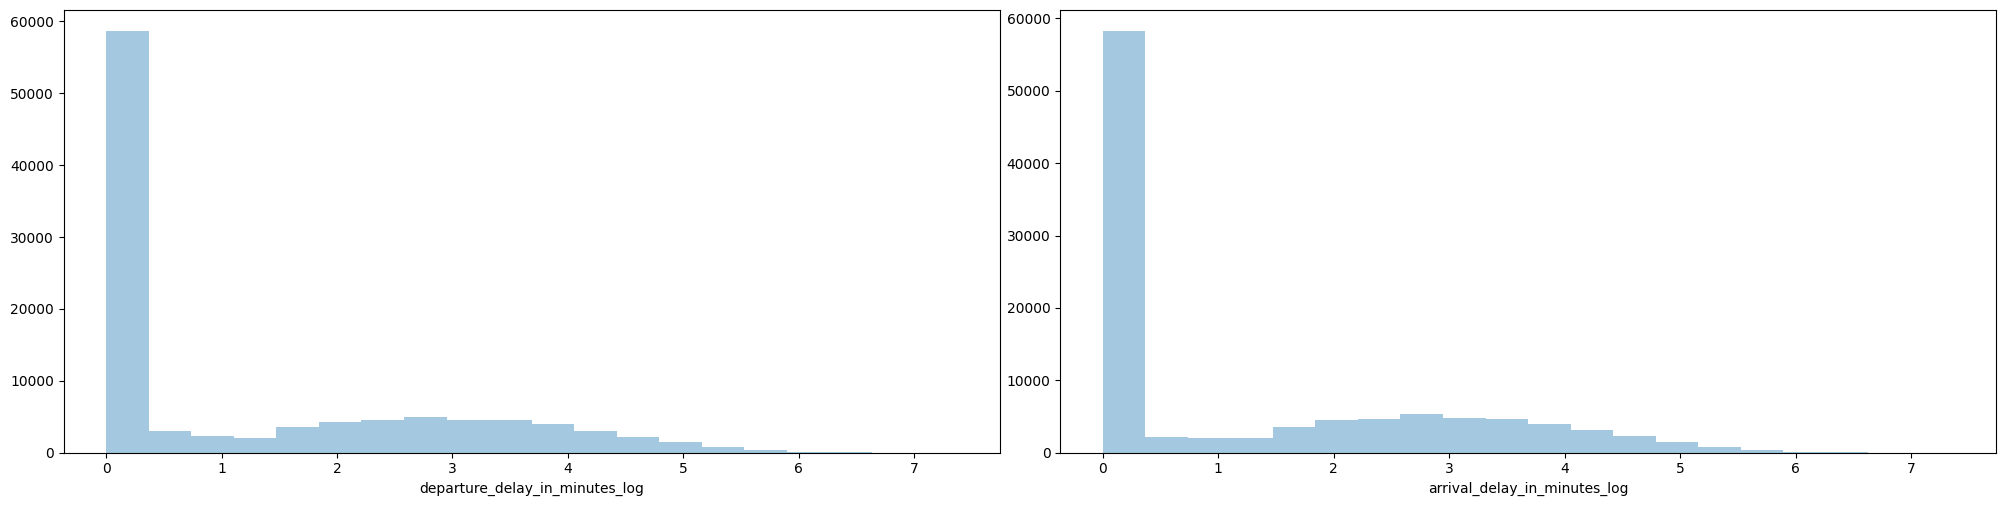

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
index = 0
axs = axs.flatten()
num_cols_3 = [
    'departure_delay_in_minutes_log',
    'arrival_delay_in_minutes_log'
]
for num_col in num_cols_3:
    num_unique_vals = df[num_col].nunique()
    num_bins = np.min([num_unique_vals, 20])
    sns.distplot(df[num_col], ax=axs[index], kde=False, bins=num_bins)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

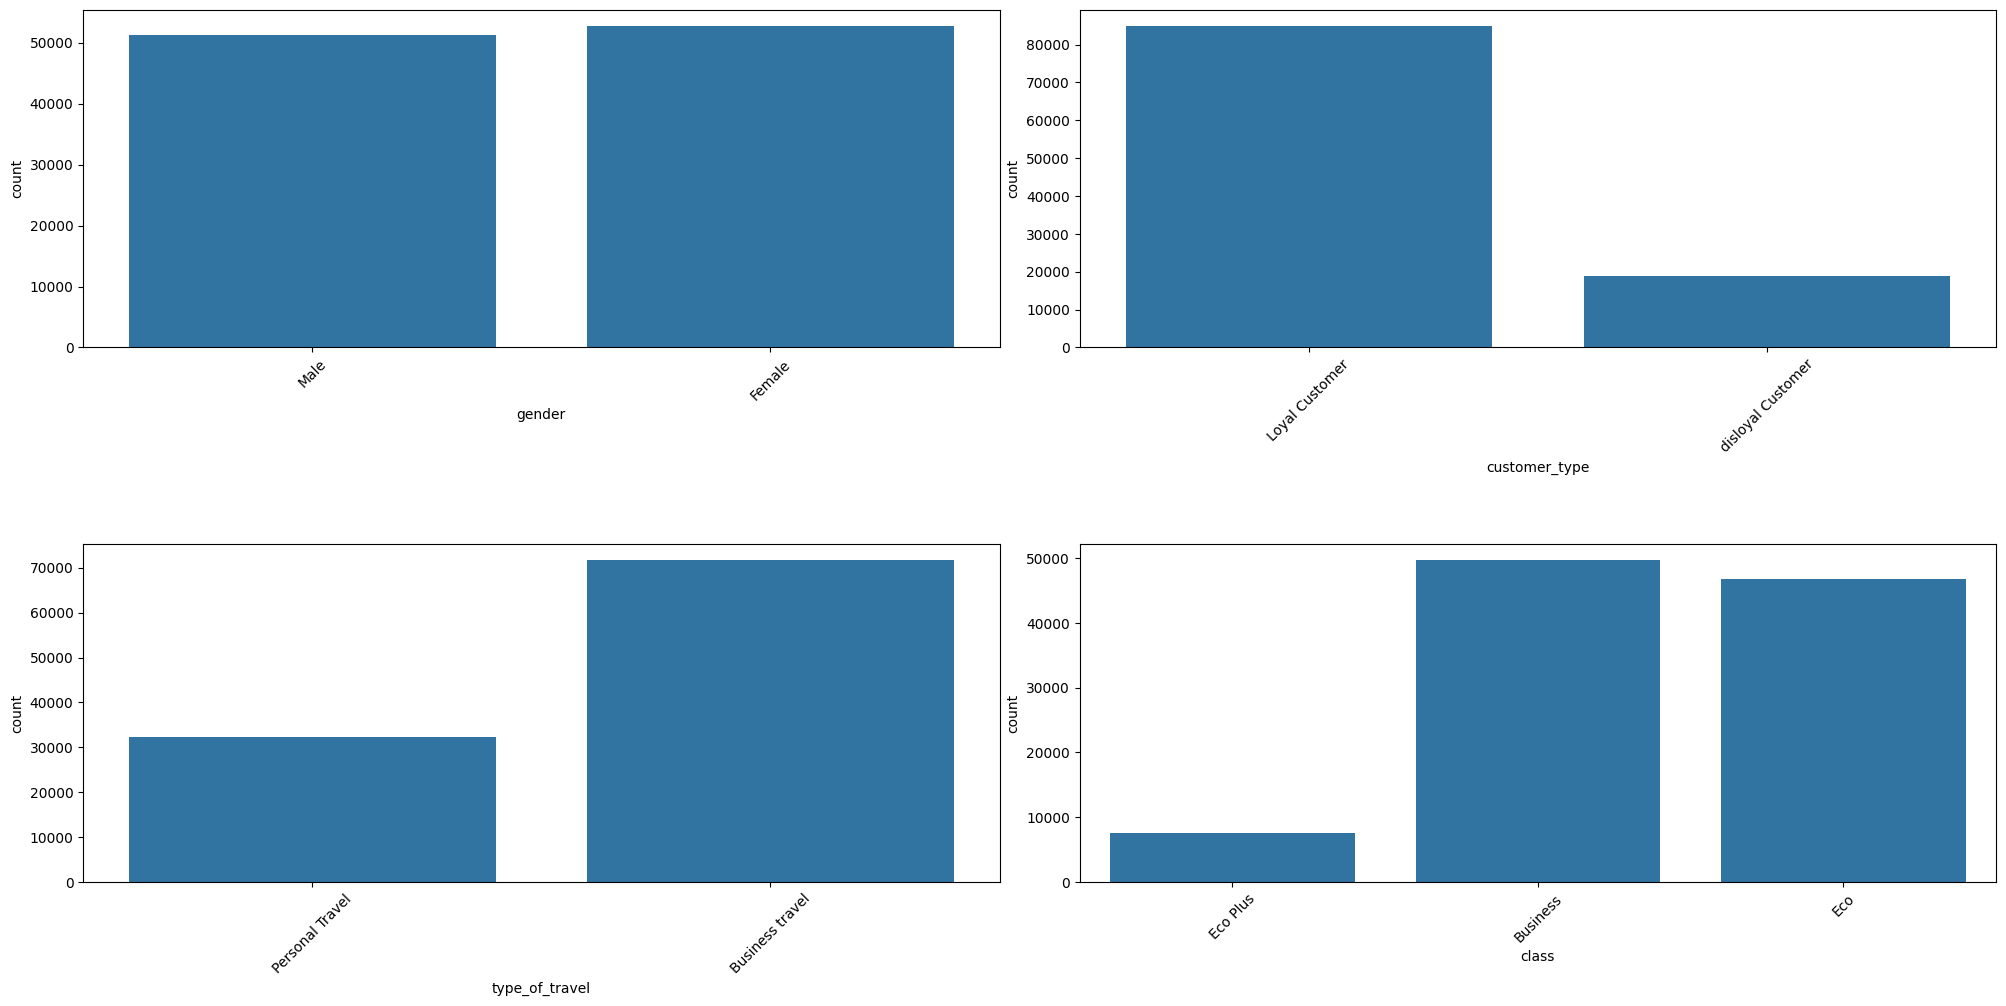

In [20]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
cat_cols = ['gender', 'customer_type', 'type_of_travel', 'class']
for cat_col in cat_cols:
    sns.countplot(x=cat_col, data=df, ax=axs[index])
    axs[index].tick_params(axis='x', rotation=45)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

In [21]:
assesment_cols = [
    'departure_arrival_time_convenient',
    'ease_of_online_booking',
    'gate_location',
    'food_and_drink',
    'inflight_wifi_service', 
    'online_boarding',
    'seat_comfort',
    'inflight_entertainment',
    'on_board_service',
    'leg_room_service',
    'baggage_handling',
    'checkin_service',
    'inflight_service',
    'cleanliness',
]
df['avg_assesment'] = df[assesment_cols].apply(np.mean, axis=1)

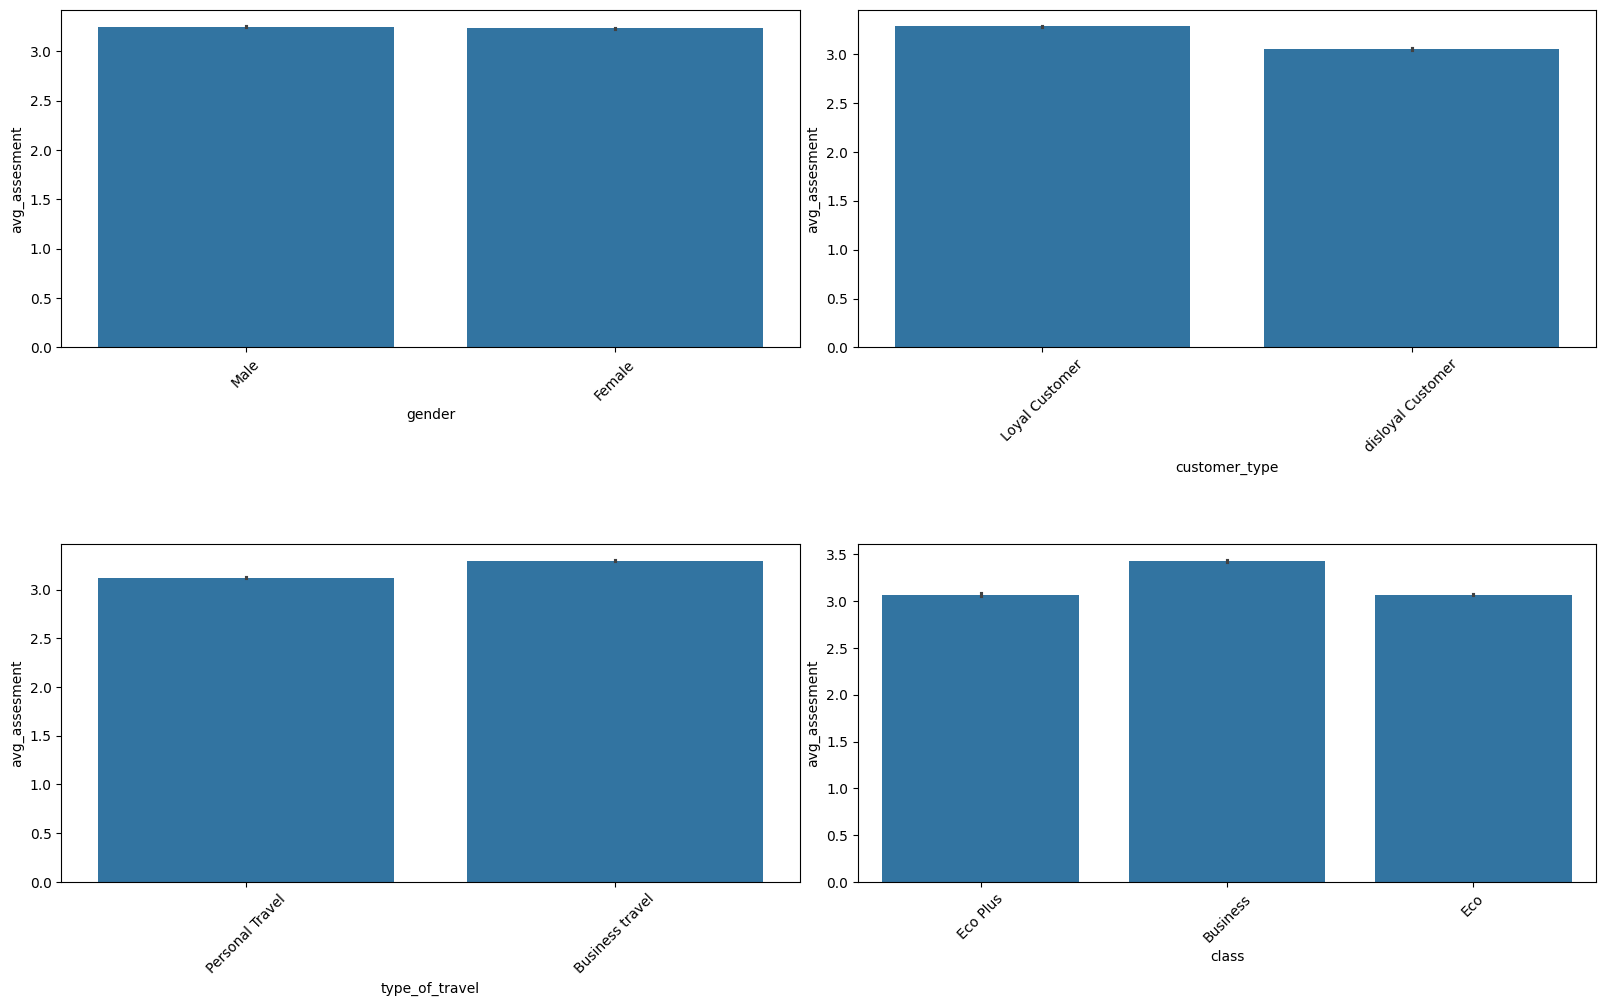

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))
index = 0
axs = axs.flatten()
for cat_col in cat_cols:
    sns.barplot(x=cat_col, y="avg_assesment", data=df, ax=axs[index])
    axs[index].tick_params(axis='x', rotation=45)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

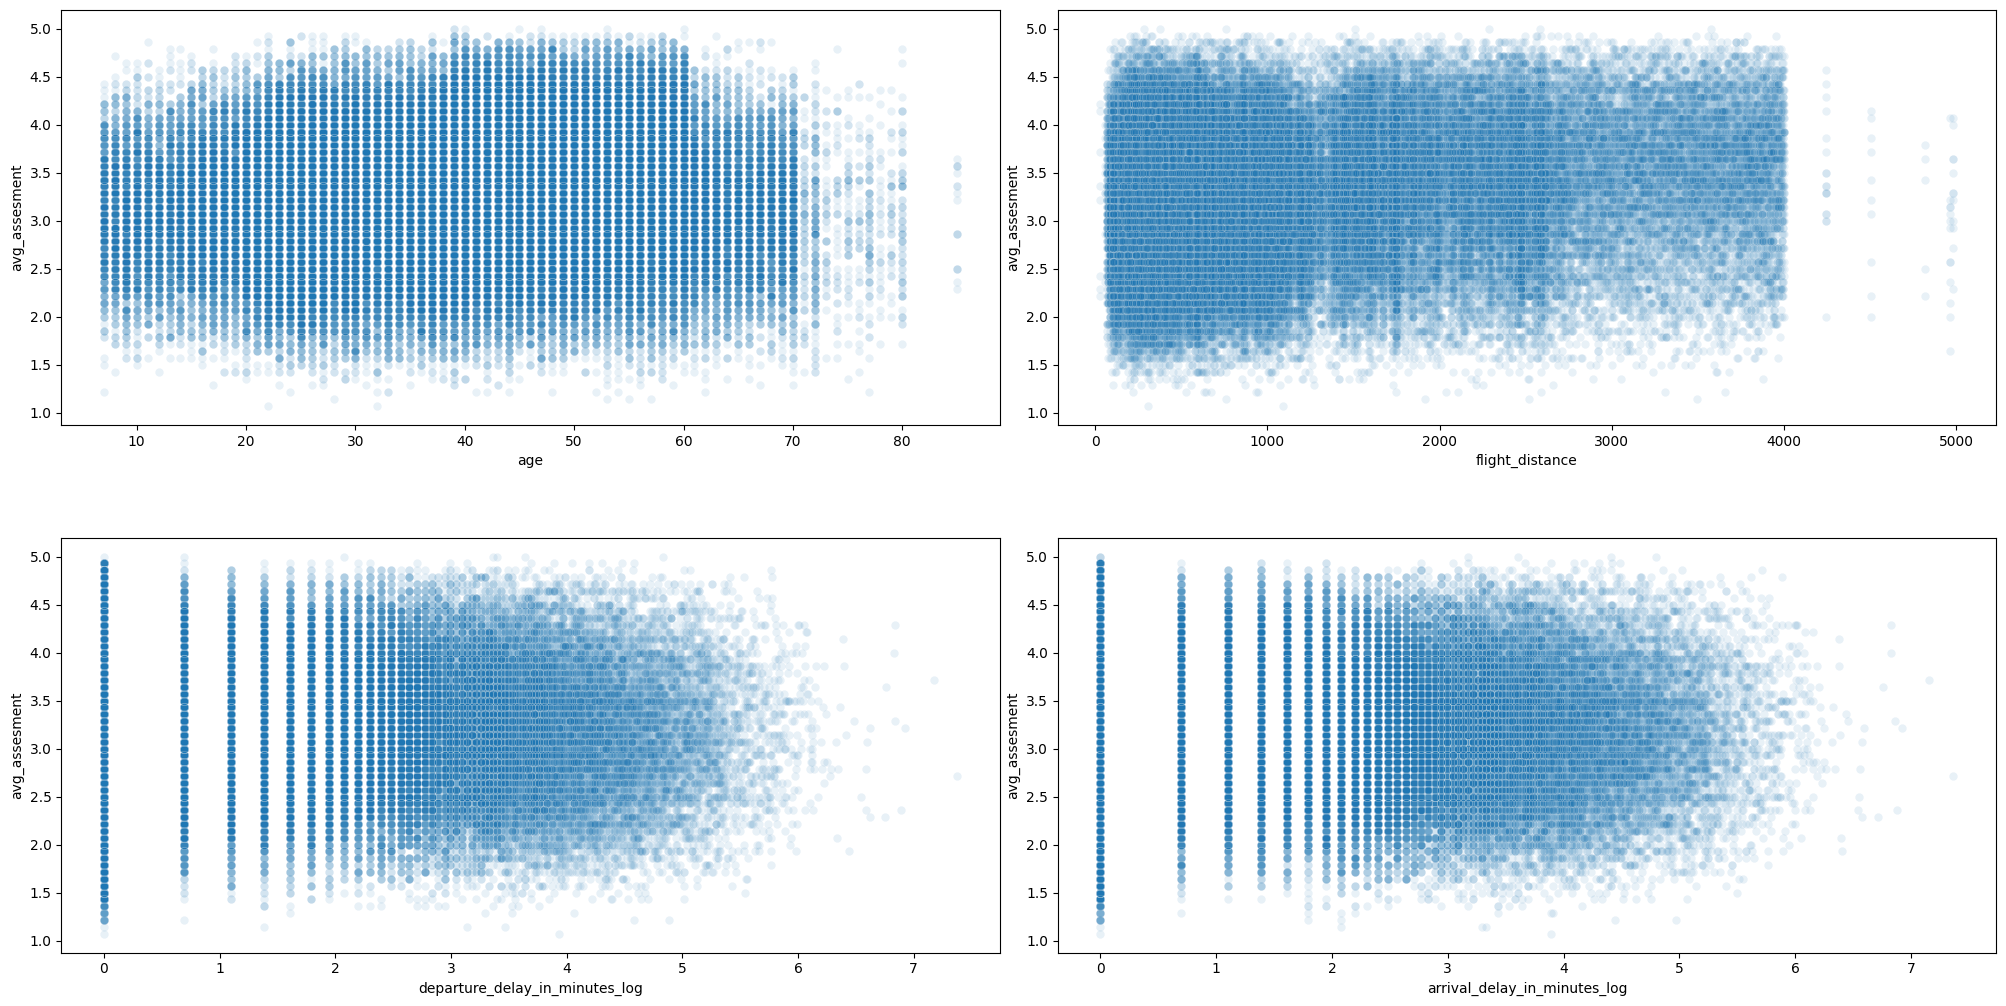

In [23]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for num_col in ['age', 'flight_distance', 'departure_delay_in_minutes_log', 'arrival_delay_in_minutes_log']:
    sns.scatterplot(x=num_col, y="avg_assesment", data=df, alpha=0.1, ax=axs[index])
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

<h2>Encoding</h2>

In [25]:
df['is_male'] = df['gender'].map({'Male': 1, 'Female': 0})
df['is_loyal'] = df['customer_type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df['is_personal'] = df['type_of_travel'].map({'Personal Travel': 1, 'Business travel': 0})
df['class_level'] = df['class'].map({'Eco': 0, 'Eco Plus': 1, 'Business': 2})

df = df.drop(columns=cat_cols)

In [26]:
df

,age,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes_log,arrival_delay_in_minutes_log,avg_assesment,is_male,is_loyal,is_personal,class_level
0,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,3.258097,2.944439,3.857143,1,1,1,1
1,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,0.693147,1.945910,2.285714,1,0,0,2
2,26,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0.000000,0.000000,3.714286,0,1,0,2
3,25,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,2.484907,2.302585,3.000000,0,1,0,2
4,61,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0.000000,0.000000,3.500000,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,23,192,2,1,2,3,2,2,2,2,3,1,4,2,3,2,1.386294,0.000000,2.214286,0,0,0,0
103900,49,2347,4,4,4,4,2,4,5,5,5,5,5,5,5,4,0.000000,0.000000,4.357143,1,1,0,2
103901,30,1995,1,1,1,3,4,1,5,4,3,2,4,5,5,4,2.079442,2.708050,3.071429,1,0,0,2
103902,22,1000,1,1,1,5,1,1,1,1,4,5,1,5,4,1,0.000000,0.000000,2.285714,0,0,0,0


In [27]:
df.corr().style.background_gradient(cmap='coolwarm')

,age,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes_log,arrival_delay_in_minutes_log,avg_assesment,is_male,is_loyal,is_personal,class_level
age,1.000000,0.099461,0.017859,0.038125,0.024842,-0.001330,0.023000,0.208939,0.160277,0.076444,0.057594,0.040583,-0.047529,0.035482,-0.049427,0.053611,-0.010721,-0.013305,0.093829,0.008928,0.281674,-0.048524,0.140565
flight_distance,0.099461,1.000000,0.007131,-0.020043,0.065717,0.004793,0.056994,0.214869,0.157333,0.128740,0.109526,0.133916,0.063184,0.073072,0.057540,0.093149,0.008044,-0.006906,0.161468,0.005828,0.225200,-0.267344,0.451211
inflight_wifi_service,0.017859,0.007131,1.000000,0.343845,0.715856,0.336248,0.134718,0.456970,0.122658,0.209321,0.121500,0.160473,0.120923,0.043193,0.110441,0.132698,-0.028282,-0.034588,0.581608,0.008974,0.007543,-0.105085,0.036279
departure_arrival_time_convenient,0.038125,-0.020043,0.343845,1.000000,0.436961,0.444757,0.004906,0.070119,0.011344,-0.004861,0.068882,0.012441,0.072126,0.093333,0.073318,0.014292,-0.000564,-0.003029,0.397613,0.009142,0.206869,0.259763,-0.092788
ease_of_online_booking,0.024842,0.065717,0.715856,0.436961,1.000000,0.458655,0.031873,0.404074,0.030014,0.047032,0.038833,0.107601,0.038762,0.011081,0.035272,0.016179,-0.008554,-0.011791,0.497097,0.006951,0.019509,-0.133511,0.106391
gate_location,-0.001330,0.004793,0.336248,0.444757,0.458655,1.000000,-0.001159,0.001688,0.003669,0.003517,-0.028373,-0.005873,0.002313,-0.035427,0.001681,-0.003830,0.004952,0.005826,0.319985,0.000333,-0.006078,-0.030700,0.004150
food_and_drink,0.023000,0.056994,0.134718,0.004906,0.031873,-0.001159,1.000000,0.234468,0.574556,0.622512,0.059073,0.032498,0.034746,0.087299,0.033993,0.657760,-0.025351,-0.035558,0.500410,0.005772,0.059454,-0.063439,0.085908
online_boarding,0.208939,0.214869,0.456970,0.070119,0.404074,0.001688,0.234468,1.000000,0.420211,0.285066,0.155443,0.123950,0.083280,0.204462,0.074573,0.331517,-0.029872,-0.044826,0.552559,-0.042260,0.189262,-0.224803,0.322924
seat_comfort,0.160277,0.157333,0.122658,0.011344,0.030014,0.003669,0.574556,0.420211,1.000000,0.610590,0.131971,0.105559,0.074542,0.191854,0.069218,0.678534,-0.024263,-0.037907,0.572257,-0.026502,0.159484,-0.124399,0.227444
inflight_entertainment,0.076444,0.128740,0.209321,-0.004861,0.047032,0.003517,0.622512,0.285066,0.610590,1.000000,0.420153,0.299692,0.378210,0.120867,0.404855,0.691815,-0.029988,-0.044444,0.713452,0.006117,0.109930,-0.148199,0.194366


In [28]:
df['delay_coef'] = df['departure_delay_in_minutes_log'] + df['arrival_delay_in_minutes_log']
df = df.drop(columns=['avg_assesment', 'departure_delay_in_minutes_log', 'arrival_delay_in_minutes_log'])

In [29]:
df.corr().style.background_gradient(cmap='coolwarm')

,age,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,is_male,is_loyal,is_personal,class_level,delay_coef
age,1.000000,0.099461,0.017859,0.038125,0.024842,-0.001330,0.023000,0.208939,0.160277,0.076444,0.057594,0.040583,-0.047529,0.035482,-0.049427,0.053611,0.008928,0.281674,-0.048524,0.140565,-0.012634
flight_distance,0.099461,1.000000,0.007131,-0.020043,0.065717,0.004793,0.056994,0.214869,0.157333,0.128740,0.109526,0.133916,0.063184,0.073072,0.057540,0.093149,0.005828,0.225200,-0.267344,0.451211,0.000568
inflight_wifi_service,0.017859,0.007131,1.000000,0.343845,0.715856,0.336248,0.134718,0.456970,0.122658,0.209321,0.121500,0.160473,0.120923,0.043193,0.110441,0.132698,0.008974,0.007543,-0.105085,0.036279,-0.033060
departure_arrival_time_convenient,0.038125,-0.020043,0.343845,1.000000,0.436961,0.444757,0.004906,0.070119,0.011344,-0.004861,0.068882,0.012441,0.072126,0.093333,0.073318,0.014292,0.009142,0.206869,0.259763,-0.092788,-0.001894
ease_of_online_booking,0.024842,0.065717,0.715856,0.436961,1.000000,0.458655,0.031873,0.404074,0.030014,0.047032,0.038833,0.107601,0.038762,0.011081,0.035272,0.016179,0.006951,0.019509,-0.133511,0.106391,-0.010701
gate_location,-0.001330,0.004793,0.336248,0.444757,0.458655,1.000000,-0.001159,0.001688,0.003669,0.003517,-0.028373,-0.005873,0.002313,-0.035427,0.001681,-0.003830,0.000333,-0.006078,-0.030700,0.004150,0.005667
food_and_drink,0.023000,0.056994,0.134718,0.004906,0.031873,-0.001159,1.000000,0.234468,0.574556,0.622512,0.059073,0.032498,0.034746,0.087299,0.033993,0.657760,0.005772,0.059454,-0.063439,0.085908,-0.032037
online_boarding,0.208939,0.214869,0.456970,0.070119,0.404074,0.001688,0.234468,1.000000,0.420211,0.285066,0.155443,0.123950,0.083280,0.204462,0.074573,0.331517,-0.042260,0.189262,-0.224803,0.322924,-0.039294
seat_comfort,0.160277,0.157333,0.122658,0.011344,0.030014,0.003669,0.574556,0.420211,1.000000,0.610590,0.131971,0.105559,0.074542,0.191854,0.069218,0.678534,-0.026502,0.159484,-0.124399,0.227444,-0.032706
inflight_entertainment,0.076444,0.128740,0.209321,-0.004861,0.047032,0.003517,0.622512,0.285066,0.610590,1.000000,0.420153,0.299692,0.378210,0.120867,0.404855,0.691815,0.006117,0.109930,-0.148199,0.194366,-0.039153


In [30]:
def calc_vif(df, drop_feat=None):
    """
    Calculate the Variance Inflation Factor (VIF) for each feature in the dataset.

    Arguments:
        df (pandas.DataFrame): DataFrame containing the feature set (independent variables).

    Returns:
        pandas.DataFrame: DataFrame containing the VIF for each feature.
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif_data

In [31]:
vif_result = calc_vif(df)
vif_result

,feature,VIF
0,age,8.034922
1,flight_distance,3.237956
2,inflight_wifi_service,12.808375
3,departure_arrival_time_convenient,8.363286
4,ease_of_online_booking,13.172609
5,gate_location,8.832464
6,food_and_drink,13.820447
7,online_boarding,13.530838
8,seat_comfort,18.468408
9,inflight_entertainment,26.883707


<h2>Normalization</h2>

In [33]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = scaler.transform(df)

<h2>Clustering analysis</h2>

In [35]:
hopkins(data_frame=scaled_df, sampling_size=1000)

0.2907892478937149

In [36]:
# from sklearn.neighbors import NearestNeighbors
# import random

# def hopkins_statistic(X, sample_size=0.1):
#     if isinstance(sample_size, float):
#         n_samples = int(sample_size * X.shape[0])
#     else:
#         n_samples = sample_size

#     d = X.shape[1]
#     nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    
#     random_indices = random.sample(range(X.shape[0]), n_samples)
#     u_distances = []
#     w_distances = []

#     for idx in random_indices:
#         rand_point = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0))
#         u_dist, _ = nbrs.kneighbors([rand_point], n_neighbors=1)
#         u_distances.append(u_dist[0][0])
        
#         w_dist, _ = nbrs.kneighbors([X[idx]], n_neighbors=2)  # другий — бо перший — це сама точка
#         w_distances.append(w_dist[0][1])

#     H = np.sum(u_distances) / (np.sum(u_distances) + np.sum(w_distances))
#     return H

# hopkins_statistic(scaled_df, 0.001)

<h2>Formulas</h2>

In [42]:
def stratified_cluster_sample(X, labels, max_per_cluster=1000, exclude_label=-1, random_state=42):
    df = pd.DataFrame(X)
    df['cluster'] = labels

    unique_labels = np.unique(labels)
    if exclude_label is not None:
        unique_labels = unique_labels[unique_labels != exclude_label]

    sampled = []

    for label in unique_labels:
        cluster_df = df[df['cluster'] == label]
        if len(cluster_df) > max_per_cluster:
            cluster_sample = cluster_df.sample(n=max_per_cluster, random_state=random_state)
        else:
            cluster_sample = cluster_df
        sampled.append(cluster_sample)

    sampled_df = pd.concat(sampled).reset_index(drop=True)
    X_sampled = sampled_df.drop(columns='cluster').values
    y_sampled = sampled_df['cluster'].values

    return X_sampled, y_sampled

In [51]:
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import euclidean

def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    max_intra = 0
    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        distances = pairwise_distances(cluster_points)
        intra_diameter = np.max(distances)
        if intra_diameter > max_intra:
            max_intra = intra_diameter

    min_inter = np.inf
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            ci = X[labels == unique_labels[i]]
            cj = X[labels == unique_labels[j]]
            for pi in ci:
                for pj in cj:
                    dist = euclidean(pi, pj)
                    if dist < min_inter:
                        min_inter = dist

    return min_inter / max_intra


In [52]:
from collections import defaultdict

def compute_within_cluster_dispersion(X, labels):
    clusters = defaultdict(list)
    for idx, label in enumerate(labels):
        if label == -1:
            continue
        clusters[label].append(idx)
    
    W_k = 0.0
    for idxs in clusters.values():
        if len(idxs) <= 1:
            continue
        cluster_points = X[idxs]
        centroid = np.mean(cluster_points, axis=0)
        squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
        W_k += np.sum(squared_distances)
    
    return W_k/(X.shape[0] - 1)

<h2>DBSCAN</h2>

In [ ]:
params = {
    'distance': [2, 2.5],
    'min_sample': [18, 20, 22, 25],
}

In [ ]:
for distance in params['distance']:
    for min_sample in params['min_sample']:
        clustering = DBSCAN(eps=distance, min_samples=min_sample).fit(scaled_df)
        num_clusters = len([x for x in set(clustering.labels_) if x != -1])
        max_cluster_sample = 1000 if num_clusters <= 3 else 3000//num_clusters
        X_sampled, y_sampled = stratified_cluster_sample(scaled_df, clustering.labels_, max_per_cluster=max_cluster_sample)
        dunn_index_val = dunn_index(X_sampled, y_sampled)
        average_silhouette = silhouette_score(X_sampled, y_sampled)
        cluster_disp = compute_within_cluster_dispersion(X_sampled, y_sampled)
        print(f'num clusters for distance {distance} and min_sample {min_sample} is {num_clusters}. Dunn index is {round(dunn_index_val, 2)}, average silhouette is {round(average_silhouette, 2)} and cluster dispersion is {round(cluster_disp, 3)}.')


<h2>BFR</h2>

In [ ]:


class BFRClustering(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=8, threshold=2.0, cs_threshold=2.0, min_points_ds=10):
        self.n_clusters = n_clusters
        self.threshold = threshold
        self.cs_threshold = cs_threshold
        self.min_points_ds = min_points_ds
        self.reset()

    def reset(self):
        self.DS = {}
        self.CS = {} 
        self.RS = [] 
        self.next_cs_id = 0

    def _create_cluster_summaries(self, X, labels):
        summaries = {}
        for i in np.unique(labels):
            points = X[labels == i]
            N = len(points)
            SUM = np.sum(points, axis=0)
            SUMSQ = np.sum(points ** 2, axis=0)
            summaries[i] = (N, SUM, SUMSQ)
        return summaries

    def _update_centroids(self, clusters):
        centroids = []
        variances = []
        for N, SUM, SUMSQ in clusters.values():
            mu = SUM / N
            var = SUMSQ / N - (mu ** 2)
            var[var < 1e-10] = 1e-10
            centroids.append(mu)
            variances.append(var)
        return np.array(centroids), np.array(variances)

    def _mahalanobis_batch(self, X, centroids, variances):
        X_exp = X[:, np.newaxis, :]
        C = centroids[np.newaxis, :, :]
        V = variances[np.newaxis, :, :]
        return np.sqrt(np.sum(((X_exp - C) ** 2) / V, axis=2))

    def _assign_to_cluster_set(self, X, clusters, threshold):
        if not clusters:
            return [-1] * len(X)
        centroids, variances = self._update_centroids(clusters)
        dists = self._mahalanobis_batch(X, centroids, variances)
        min_dists = np.min(dists, axis=1)
        min_indices = np.argmin(dists, axis=1)
        return [idx if d < threshold else -1 for d, idx in zip(min_dists, min_indices)]

    def _merge_CS(self):
        if len(self.CS) < 2:
            return
        centroids, variances = self._update_centroids(self.CS)
        to_merge = []
        for i in range(len(centroids)):
            for j in range(i + 1, len(centroids)):
                dist = np.sqrt(np.sum((centroids[i] - centroids[j]) ** 2 / variances[i]))
                if dist < self.cs_threshold:
                    to_merge.append((i, j))

        merged = {}
        skip = set()
        for i, j in to_merge:
            if i in skip or j in skip:
                continue
            a = list(self.CS.values())[i]
            b = list(self.CS.values())[j]
            N = a[0] + b[0]
            SUM = a[1] + b[1]
            SUMSQ = a[2] + b[2]
            merged[self.next_cs_id] = (N, SUM, SUMSQ)
            self.next_cs_id += 1
            skip.update([i, j])

        new_CS = {}
        for k, (cid, stats) in enumerate(self.CS.items()):
            if k not in skip:
                new_CS[cid] = stats
        new_CS.update(merged)
        self.CS = new_CS

    def _promote_CS_to_DS(self):
        promote_ids = [cid for cid, (N, _, _) in self.CS.items() if N >= self.min_points_ds]
        for cid in promote_ids:
            self.DS[cid] = self.CS.pop(cid)

    def partial_fit(self, X):
        X = np.asarray(X)

        if not self.DS and not self.CS:
            km = KMeans(n_clusters=self.n_clusters, random_state=42, n_init='auto').fit(X)
            self.DS = self._create_cluster_summaries(X, km.labels_)
            return

        assigned_DS = self._assign_to_cluster_set(X, self.DS, self.threshold)
        remaining_X = []
        for i, x in enumerate(X):
            cid = assigned_DS[i]
            if cid == -1:
                remaining_X.append(x)
            else:
                N, SUM, SUMSQ = self.DS[cid]
                self.DS[cid] = (N + 1, SUM + x, SUMSQ + x ** 2)

        remaining_X = np.array(remaining_X)
        if len(remaining_X) == 0:
            return

        assigned_CS = self._assign_to_cluster_set(remaining_X, self.CS, self.cs_threshold)
        cs_keys = list(self.CS.keys())
        new_RS = []
        for i, x in enumerate(remaining_X):
            cid = assigned_CS[i]
            if cid == -1:
                new_RS.append(x)
            else:
                actual_cid = cs_keys[cid]
                N, SUM, SUMSQ = self.CS[actual_cid]
                self.CS[actual_cid] = (N + 1, SUM + x, SUMSQ + x ** 2)


        if new_RS:
            self.RS.extend(new_RS)

        if len(self.RS) >= self.n_clusters * 5:  # optional threshold
            RS_arr = np.array(self.RS)
            km = KMeans(n_clusters=min(len(RS_arr), self.n_clusters), random_state=42, n_init='auto').fit(RS_arr)
            labels = km.labels_
            self.RS = []

            for i in range(km.n_clusters):
                cluster_points = RS_arr[labels == i]
                if len(cluster_points) >= 2:
                    self.CS[self.next_cs_id] = (
                        len(cluster_points),
                        np.sum(cluster_points, axis=0),
                        np.sum(cluster_points ** 2, axis=0)
                    )
                    self.next_cs_id += 1
                else:
                    self.RS.append(cluster_points[0])

        self._merge_CS()
        self._promote_CS_to_DS()

    def predict(self, X):
        X = np.asarray(X)
        labels = self._assign_to_cluster_set(X, self.DS, self.threshold)
        return np.array(labels)

    def fit(self, X, batch_size=100):
        for i in range(0, len(X), batch_size):
            self.partial_fit(X[i:i + batch_size])
        return self

    def fit_predict(self, X, batch_size=100):
        self.fit(X, batch_size=batch_size)
        return self.predict(X)


In [ ]:
ms = [2, 5, 10, 20]
cluster_counts = []

for m in ms:
    bfr = BFRClustering(n_clusters=10, threshold=m)
    bfr.fit(scaled_df, 10000)
    cluster_counts.append(len(bfr.DS))

In [ ]:
ms = [2]

for m in ms:
    bfr = BFRClustering(n_clusters=10, threshold=m)
    bfr.fit(scaled_df, 10000)
    labels = bfr.predict(scaled_df)
    max_cluster_sample = 1000 if num_clusters <= 3 else 3000//num_clusters
    X_sampled, y_sampled = stratified_cluster_sample(scaled_df, labels, max_per_cluster=max_cluster_sample)
    dunn_index_val = dunn_index(X_sampled, y_sampled)
    average_silhouette = silhouette_score(X_sampled, y_sampled)
    cluster_disp = compute_within_cluster_dispersion(X_sampled, y_sampled)
    print(f'BFR for threshold {m}. Dunn index is {round(dunn_index_val, 2)}, average silhouette is {round(average_silhouette, 2)} and cluster dispersion is {round(cluster_disp, 3)}.')


In [ ]:
plt.plot(ms, cluster_counts, marker='o')
plt.xlabel("Значення параметра m (threshold)")
plt.ylabel("Кількість кластерів")
plt.title("Залежність кількості кластерів від параметра m")
plt.grid(True)
plt.show()

<h2>BIRCH</h2>

In [69]:
sample_size = 20000
indices = np.random.choice(scaled_df.shape[0], sample_size, replace=False)
data = scaled_df[indices]

birch_model = Birch(threshold=0.5, branching_factor=100, n_clusters=3)
birch_model.fit(data)
labels = birch_model.predict(data)

In [73]:
X_sampled, y_sampled = stratified_cluster_sample(data, labels, max_per_cluster=1000)
dunn_index_val = dunn_index(X_sampled, y_sampled)
average_silhouette = silhouette_score(X_sampled, y_sampled)
cluster_disp = compute_within_cluster_dispersion(X_sampled, y_sampled)
print(f'Birch model. Dunn index is {round(dunn_index_val, 2)}, average silhouette is {round(average_silhouette, 2)} and cluster dispersion is {round(cluster_disp, 3)}.')


Birch model. Dunn index is 0.14, average silhouette is 0.12 and cluster dispersion is 16.91.


<h2>CURE</h2>

In [61]:
from pyclustering.cluster.cure import cure


sample_size = 2000 
number_of_clusters = 5
represent_points = 4
compression = 0.6

indices = np.random.choice(scaled_df.shape[0], sample_size, replace=False)
data = scaled_df[indices]

cure_instance = cure(
    data,
    number_of_clusters,
    represent_points,
    compression
)

cure_instance.process()
clusters = cure_instance.get_clusters()
labels = pd.Series([-1] * sample_size)
for i, cluster_repr in enumerate(clusters):
    labels.iloc[cluster_repr] = i

dunn_index_val = dunn_index(data, labels)
average_silhouette = silhouette_score(data, labels)
cluster_disp = compute_within_cluster_dispersion(data, labels)
print(f'Cure model. Dunn index is {round(dunn_index_val, 2)}, average silhouette is {round(average_silhouette, 2)} and cluster dispersion is {round(cluster_disp, 3)}.')


Cure model. Dunn index is 0.33, average silhouette is 0.05 and cluster dispersion is 20.766.
